<p style="font-size:30px"><b> 4th Model - Majority with additional social networks</b></p>
 
<p style="font-size:20px">The main assumptions of this model are following:</p>
<ol>
    <li>
        There are <font color="red">six graphs</font>, which represents interactions in society: 
        <ul>
            <li><b>G</b> - rectangular neighbourhood network</li>
            <li><b>K</b> - social interactions network</li>
            <li><b>K_temp</b> - <font color="red">three </font> temporary social interactions network (generates for each iteration)</li>
            <li><b>L</b> - social media network (social media are for or against EV - it changes in each iteration)</li>
        </ul>
    </li>
    <li>
        There are two different possibilities in opinions:
        <ul>
            <li><b>1</b> - agent is against EV</li>
            <li><b>-1</b> - agent is for EV</li>
        </ul>
    </li>
    <li>
        <font color="red">At the beginning there are agents with different opinions (based on real number of EV)</font>
    </li>
    <li>
        There are two possibilities of changing opinion by agents:
        <ul>
            <li><b>independent flip</b> - with a given probability $p$ agent changes its opinions independently</li>
            <li><b>conformity flip</b> - if <font color="red">majority</font> of $q$ neighbours from each considered network have the same opinion, agents change their opinion for the same as <font color="red">majority</font></li>
        </ul>
</ol>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import trange
import pickle

In [2]:
def spinson_independent_flip(opinions, spinson):
    opinions[spinson] = -1 if opinions[spinson] == 1 else 1
    
    return opinions

In [3]:
def spinson_conformity_flip_v2(graphs, opinions, spinson, q):
    neighbours = []
    # Choosing q neighbours from all considered graphs
    for graph in graphs: 
        if len(list(graph.neighbors(spinson))) < q:
            neighbours.extend(list(graph.neighbors(spinson)))
        else:
            neighbours.extend(random.sample(list(graph.neighbors(spinson)), q))
    neighbours_opinions = [opinions[neighbour] for neighbour in neighbours]
    # in a set of neighbours opinions there is only one value
    # edge between social media node and spinson has the same value as other neighbours
    neighbours_opinions.append(graphs[-1].edges[(66, spinson)]['media'][0])
    if neighbours_opinions.count(-1) > neighbours_opinions.count(1):
        opinions[spinson] = -1
    else:
        opinions[spinson] = 1

    return opinions

In [5]:
def q_voter_simulation_v2(graphs, p, q, iterations):
    magnetization = []

    opinions = [1]*len(G)
    while opinions.count(-1) < 4:  # agents have different opinions
        opinions[random.randint(0, len(G)-1)] = -1
    
    social_media_opinion = [1] 
    opinions = opinions + social_media_opinion
    
    magnetization.append(sum(opinions[:-1])/len(graphs[0]))
    for i in range(iterations):
        # in every iteration graph of temporary interactions and opinion of social media is changing
        for j in range(2, 5):
            graphs[j] = nx.fast_gnp_random_graph(len(graphs[0].nodes()), random.uniform(0.01, 0.1))
        opinions[-1] = random.choice([-1, 1]) # social media influence change opinion
        # choosing neighbours
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  #  does it act independtly?
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip_v2(graphs, opinions, spinson, q)

        magnetization.append(sum(opinions[:-1])/len(graphs[0]))

    return magnetization

In [6]:
def calculate_magnetization(graphs, p, q, mc, iterations):
    magnetizations = []
    final_magnetizations = []
    if type(p) == list and type(q) != list:
        for j in range(len(p)):  
            magnetization = np.zeros(iterations+1)
            for i in range(mc):    
                magnetization = magnetization + q_voter_simulation_v2(graphs, p[j], q, iterations)
            magnetizations.append(magnetization/mc)
            final_magnetizations.append(magnetization[-1]/mc)
            
    elif type(p) != list and type(q) == list:
        for j in range(len(q)):  
            magnetization = np.zeros(iterations+1)
            for i in range(mc):    
                magnetization = magnetization + q_voter_simulation_v2(graphs, p, q[j], iterations)
            magnetizations.append(magnetization/mc)
            final_magnetizations.append(magnetization[-1]/mc)
        
    return magnetizations, final_magnetizations

## Loading saved

In [7]:
G = nx.read_gpickle('network_neighbourhood.pickle')
K = nx.read_gpickle('social_neighbourhood.pickle')
L = nx.read_gpickle('social_media.pickle')

# Simulations

### Independent runs for $p = 0.2$ and $q=3$

In [38]:
graphs = [G, K, None, None, None, L]
p = 0.3
q = 5
iterations = 100

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.27it/s]


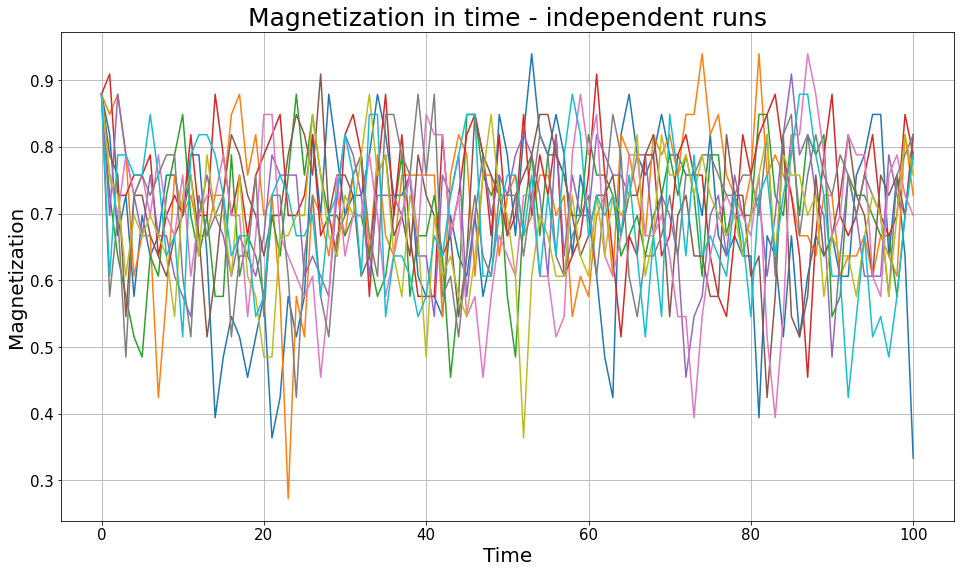

In [39]:
plt.figure(figsize=(16, 9))
for _ in trange(10):
    x = q_voter_simulation_v2(graphs, p, q, iterations)
    plt.plot(x)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title('Magnetization in time - independent runs', fontsize=25)
plt.grid()

## Magnetization for different values of $𝑝 = (0.1, 0.3, 10)$ and $𝑞=5$

In [41]:
graphs = [G, K, None, None, None, L]
ps = np.linspace(0.01, 0.3, 10)
q = 5
mc = 10
iterations = 100

In [42]:
magnetizations, final_magnetizations = [], []
for p in trange(len(ps)):
    x, y = calculate_magnetization(graphs, [ps[p]], q, mc, iterations)
    magnetizations.append(x)
    final_magnetizations.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


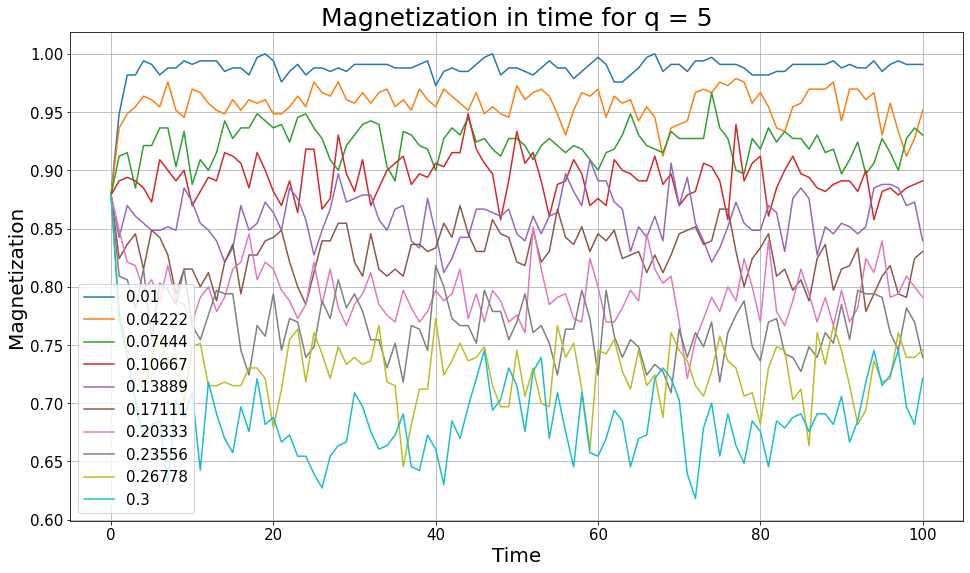

In [43]:
plt.figure(figsize=(16, 9))
for i, magnetization in enumerate(magnetizations):
    plt.plot(range(0, len(magnetization[0])), magnetization[0], label=f'{round(ps[i], 5)}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title(f'Magnetization in time for q = {q}', fontsize=25)
plt.grid()
plt.legend(prop={'size': 15})

## Magnetization for different values of $𝑝 = (0.1, 0.5, 10)$ and $𝑞=4$

In [46]:
graphs = [G, K, None, None, None, L]
ps = np.linspace(0.1, 0.5, 10)
q = 4
mc = 10
iterations = 100

In [47]:
magnetizations, final_magnetizations = [], []
for p in trange(len(ps)):
    x, y = calculate_magnetization(graphs, [ps[p]], q, mc, iterations)
    magnetizations.append(x)
    final_magnetizations.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.42s/it]


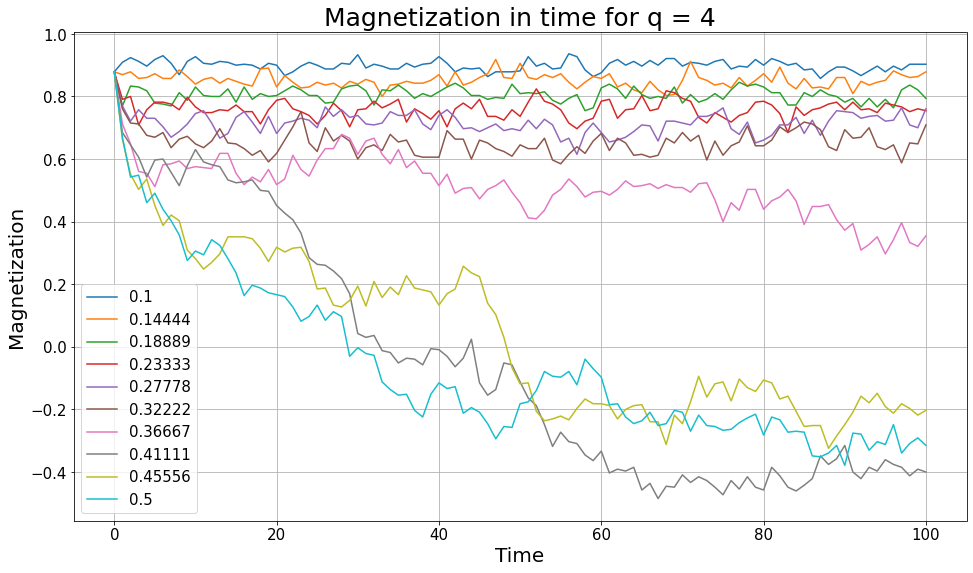

In [48]:
plt.figure(figsize=(16, 9))
for i, magnetization in enumerate(magnetizations):
    plt.plot(range(0, len(magnetization[0])), magnetization[0], label=f'{round(ps[i], 5)}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title(f'Magnetization in time for q = {q}', fontsize=25)
plt.grid()
plt.legend(prop={'size': 15})

## Magnetization for different values of $q = (1, 10, 10)$ and $p=0.35$

In [54]:
graphs = [G, K, None, None, None, L]
p = 0.35
qs = np.linspace(1, 10, 10)
mc = 10
iterations = 100

In [55]:
magnetizations, final_magnetizations = [], []
for q in trange(len(qs)):
    x, y = calculate_magnetization(graphs, p, [int(qs[q])], mc, iterations)
    magnetizations.append(x)
    final_magnetizations.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]


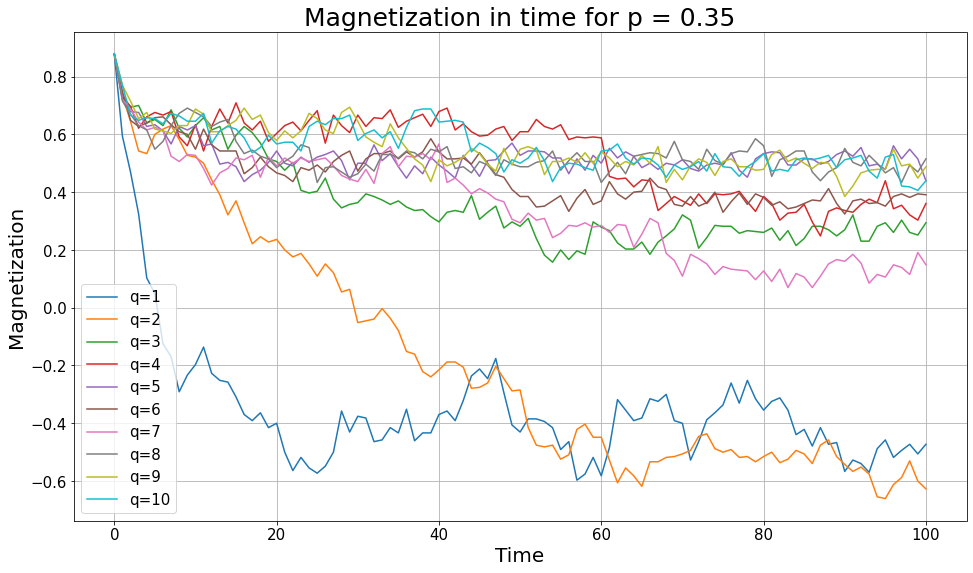

In [56]:
plt.figure(figsize=(16, 9))
for i, magnetization in enumerate(magnetizations):
    plt.plot(range(0, len(magnetization[0])), magnetization[0], label=f'q={round(qs[i])}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title(f'Magnetization in time for p = {p}', fontsize=25)
plt.grid()
plt.legend(prop={'size': 15})